<pre>
Intended Module: research_optimizer
Author: Jarrod Wilcox
Version: 0.2.1
Date: 6/30/2020
Contact:  jarrod@wealthmate.com

research_optimizer is a basic research program to read a clean file, fully-populated, of prices adjusted for any distributions, or alternatively, a return file, and then to produce portfolio allocations with analytics comparing best allocations from scenario-based probability distributions of expected ln(1+Lr), or Rubinstein, utility with those from Markowitz's mean-variance approach.

Distributed as is, with MIT license, suitable for education and research.

Oldest installable dependencies tested:  python 3.8.3, numpy 1.15.4, scipy 1.4.1, pandas 1.03, 
jupyter 1.0.0, matplotlib 3.2.1, seaborn 0.10.1, cvxpy 1.1.1.

SAMPLE INPUTS:
journalfile='JOURNAL.txt'
logfile='RUN39.txt'
sample='40YR'
meanfile='CDATA40/asset_mean.csv'
codefile='CDATA40/equiv.csv'
sourcefile='CDATA40/prices.csv'
sourcetype='PRICES'
Llist=[1, 2, 4, 8, 16]
splithalf=1
mod_method='sub_means'
long_only=False
return_interval=8
worst=-0.99

journalfile: a file to append a list of run input descriptors to be used as a directory for
    various optimization runs

logfile: a file that mirrors the printed program output for this set of inputs

sample: arbitrary text describing the run to jog the researcher's memory

meanfile: file containing estimated mean returns per period for any securities where a priori 
estimated returns are to have a designated mean applied to all member securities within an asset group

codefile: a path to a csv file containing two columns, security tickers or other ids and
    their asset categories  or "NOGROUPS"

sourcefile: a path to a csv price or return file (sorted by oldest-first, regular dates and adjusted for dividends and interest) with column headers identifying the security (usually a ticker), with the left-most column 'Date'

sourcetype:  designation of whether the return source is in terms of prices or returns.
    
Llist: a vector of risk aversion coefficients, with larger numbers representing more conservatism.

splithalf: 0,1,or 2, with 0 signifying use whole sample, 1 to use first half to learn, and last half to test,
    and 2 vice versa.

mod_method:  In this version, use either 'mirror', to give no return modification, or 'sub_means', causing the program to modify returns to induce all members of a group  to have the same mean return within the learning sample.  The researcher may write their own function to modify or add rows to the return matrix.

long_only: True induces allocation constraints insuring all allocations lie on the interval 0,1. False allows long-short funds (recommended only for research unless the user knows how to modify the return matrix or the constraints of the solution!).

return_interval: Returns are calculated by a comparison of current price and the price from regular_interval
    rows older

worst= -0.99:  If the solution is feasible, constrains allocations not to produce a portfolio return for any scenario less than worst.  If no feasible solution exists, a "best efforts" solution is presented, along with a message than no solution can meet the constraints.

Sample data files are included in the repository.


EXPECTED OUTPUT:
Produces screen output, a logfile with a printout of program input and results, and appends its input
    descriptions to a journal file.

An article "Better Portfolios with Higher Moments" by Jarrod Wilcox, to be published in the Journal of Asset Management in 2020, provides further details on the approach.
</pre>

In [ ]:

import sys
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.optimize import fmin_slsqp as slsqp
from datetime import datetime
from math import exp, isnan
try:
    import cvxpy as cp    
except:
    print ('This version of research_optimizer requires installation of cvxpy.')
    raise
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

GET PRIOR ASSET RETURN MEANS

In [ ]:
def load_asset_means(meanfile=None):
    try:
        ameans=pd.read_csv(meanfile).values
        means_lookup={row[0]:row[1] for row in ameans}
        return(means_lookup)
    except:
        print('NO ASSET MEANS FOUND')
        raise
    


GET ASSET GROUP CATEGORIES

In [ ]:
# get asset group codes
def load_asset_codes(codefile=None):
    try:
        equivs=pd.read_csv(codefile).values
        equivs=[x if isinstance(x[1],str) else [x[0],'NOGROUP'] for x in equivs]
        lookup_group={}
        for tick in equivs:
            lookup_group[tick[0]]=tick[1]
        members={}
        categories=sorted(set([x[1] for x in equivs]))
        for group in categories:
            members[group]=[x[0] for x in equivs if x[1]==group]     
        return(lookup_group,members)
    except:
        print('NO ASSET CATEGORIZATION FOUND')
        raise

#a,b=load_asset_codes('CDATA40/equiv.csv')
#print(b)

LOAD INPUT PRICE FILE

In [ ]:
def load_source(sourcefile):
    try:
        source=pd.read_csv(sourcefile)
        temp=source.get('Date')
        if not temp is None:
            source.index=temp #watch out if date misstyped
            source=source.drop(columns=['Date'])
        return source
    except:
        print('NO SOURCE FOUND')
        return None

REARRANGE COLUMNS BY ASSET CLASS IF SOURCE IS RETURN FILE

In [ ]:
def rearrange(members,source):
    cols=[tick for group in members for tick in members[group]]
    source2=pd.DataFrame(columns=cols,index=source.index)
    for tick in cols:
        source2[tick]=source[tick]
    return(source2)

CALCULATE RETURNS

In [ ]:
def calculate_returns(prices2,return_interval):
    price_data=np.array(prices2.values,dtype='float32')
    price_data1=np.ones((price_data.shape[0],price_data.shape[1]))
    price_data1[return_interval:]=price_data[:-return_interval]
    returns=(price_data/price_data1)
    returns=returns[return_interval:]-1. 
    returns_df=pd.DataFrame(returns)   
    returns_df.columns=prices2.columns
    returns_df.index=prices2.index[return_interval:]
    return(returns_df)

COLLECT FURTHER STATISTICS

In [ ]:

def rtn_summary(returns,tickers):
    means=np.mean(returns,axis=0) 
    covs=np.cov(returns.T)
    stdevs=np.std(returns,axis=0)
    corrs=np.round_(np.corrcoef(returns.T),2)
    corr=pd.DataFrame(corrs,columns=tickers)
    #cov=pd.DataFrame(covs,columns=tickers)
    means=pd.Series(means)
    stdev=pd.Series(stdevs)
    skews=stats.skew(returns,axis=0)
    skew=pd.Series(skews)
    kurts=stats.kurtosis(returns,axis=0,fisher=False)
    kurt=pd.Series(kurts)
    descript=pd.DataFrame({'TICKER':tickers,'MEAN':np.round(means,4),
        'STDEV':np.round(stdev,4),'SKEW':np.round(skew,2),'KURT':np.round(kurt,2)})
    combined=descript.join(corr,how='outer')      
        
    return (means,covs,skews,kurts,combined)
#means,covs,skews,kurts=rtn_summary(returns)

OPTIONALLY SPLIT SAMPLE INTO SMALLER LEARN AND VALIDATE SUBSAMPLES

In [ ]:
def  learning_returns(rtns,splithalf=0):
    #rtns is np array, not dataframe
    nrows = rtns.shape[0]
    #set up split sample if desired
    if splithalf not in [0,1,2]:
        print('Invalid splithalf parameter, valid are 0,1,2.')
        sys.exit('Fatal error in describe_returns function')
    print('SPLITHALF CODE: ',splithalf)
    if splithalf==0:
        learn_returns=rtns[::]
        test_returns=(0,)
    else:
        temp=int(nrows/2)
        if splithalf==1:
            learn_returns=rtns[:temp]
            test_returns=rtns[temp:]
        elif splithalf==2:
            learn_returns=rtns[temp:]
            test_returns=rtns[:temp]
    return(learn_returns,test_returns)


OPTIONAL METHODS FOR MODIFYING RETURN MATRIX FOR BETTER PREDICTION:

OPTIONAL MODIFICATION: ADJUST MEANS OF STOCK RETURNS TO HAVE SAME GRAND MEAN RETURNS

In [ ]:
def sub_means(rtn_df,members,means_lookup):
    #modify return matrix by making means equal within a secursity equivalence group
    #subtract column means and add group mean from elements in group columns
    for group in members:
        if group=='NOGROUP':
            continue
        glist= members.get(group)
        if glist and len(glist)>0: 
            secmeans=rtn_df[glist].mean()
            #gmean=secmeans.mean()
            gmean=means_lookup.get(group)/100.0
            rtn_df[glist] += (gmean-secmeans)
    return rtn_df

DISPATCHER FOR CHOICE AMONG OPTIONAL RETURN MATRIX MODIFICATIONS

In [ ]:
def modify_returns(rtn_df,mod, members,mean_lookup):  #asset classes = {'stocks': [stocklist]}   
    if mod=='sub_means':
        return sub_means(rtn_df,members,mean_lookup)       
    else:
        return rtn_df

SLSQP HILL-CLIMBING OPTIMIZER

In [ ]:
def default_init_allocate(returns_df):
    ncols=len(returns_df.columns)
    def_init_alloc=np.zeros(ncols,dtype='float64')
    stdevs=np.std(returns_df,axis=0)
    mn=np.min(stdevs)
    idx=[i for i,v in enumerate(stdevs) if v==mn][0]
    def_init_alloc[idx]=1.0        
    return def_init_alloc

def eqcons1(x,*args): #budget constraint
    return(np.array([np.sum(x)-1.0]))

def mobjective(x,means,covariance,risk_aversion):
    mn=np.dot(x,means)
    cv=np.matmul(x.T,covariance)
    cv2=np.dot(cv,x)
    return(-mn+risk_aversion*cv2/2.0)

def wobjective2(x,levreturns,worst,leverage):
    levportreturn=np.matmul(levreturns,x)
    squeeze=(1.0+worst)/leverage  #for compressing over 100% losses to nearly 100%    
    new_worst=worst+(levportreturn+1.0)*squeeze #compressing
    safeportreturn=np.maximum(levportreturn,new_worst)     
    log_portreturn=np.log1p(safeportreturn) #log(1+X) numpy function
    return (-np.sum(log_portreturn))

#-----------------------------------------------------------

def hill_climb(returns,levs,means,covs,headers,labels,long_only,worst,ob,alloc_mat=None):
    merit=pd.DataFrame(index=headers,columns=labels)
    ncols2=returns.shape[1]
    nrows2=returns.shape[0]
    nlevs=len(levs)   
    alloc=np.ones((nlevs,ncols2),dtype='float64')
    prtns=np.zeros((nlevs,nrows2),dtype='float64')
    returns_df=pd.DataFrame(returns)
    def_init_alloc=default_init_allocate(returns_df)
    if not long_only:
        print('Not set up for long-short problems')
        raise
    #long-only bounds
    upper=np.ones(ncols2,dtype='float64')
    lower=np.zeros(ncols2,dtype='float64')
    bounds=list(zip(lower,upper))
   
    for i in range(nlevs):     #in this use where called by cvxpy call, keep iteration over single leverage  
        lev=levs[i]
        levreturn=returns*lev
        
        if alloc_mat is None:
            x0=default_init_allocate(returns_df)
        else:
            x0=alloc_mat[i]
            
        if ob=='MV':
            # run mean_variance optimizer                                   
            temp=slsqp(mobjective,x0,eqcons=[eqcons1],args=tuple((means,covs,lev)),bounds=bounds,full_output=True,acc=1e-07) 
            alloc[i]=temp[0]
        
        if ob=='LLS':
            # run LLS optimizer
            levreturns=returns*lev      
            temp=slsqp(wobjective2,x0,eqcons=[eqcons1],args=tuple((levreturns,worst,lev)),bounds=bounds,full_output=True,acc=1e-08)
            alloc[i]=temp[0]
    return (None,alloc[::],None)


CVXPY OPTIMIZER

In [ ]:
def optim_with_cvxpy2(rtns,levs,means,covs,headers,labels,long_only,worst,ob):
    barrier=worst+1
    merit=pd.DataFrame(index=headers,columns=labels)
    nrows,ncols=rtns.shape
    nlevs=len(levs)
    mns=means.values
    alloc=np.ones((nlevs,ncols),dtype='float64')
    prtns=np.zeros((nlevs,nrows),dtype='float64')
    
    xx=cp.Variable(ncols)
    for i in range(nlevs):
        lev=levs[i]
        levreturn=(rtns*lev)
        print(' ')       
        print("Risk Aversion: ",lev)
        if ob=='MV':
            if long_only:
                constraints =[sum(xx)==1, 0<=xx, xx<=1] #Long-only portfolios
            else:
                constraints = [sum(xx)==1.0] 
            objective=cp.Minimize(-cp.sum(cp.multiply(mns,xx)) + lev*cp.quad_form(xx,covs)/2.0)
            prob=cp.Problem(objective,constraints)
            #result=prob.solve(verbose=True,eps_abs=1e-9,eps_rel=1e-9)
            result=prob.solve(eps_abs=1e-7,eps_rel=1e-7)
            xxvalue=xx.value
            prtns[i]=np.dot(rtns,xxvalue)
            merit['M_objective'][headers[i]]= -result
            merit['W_objective'][headers[i]]= np.sum(np.log1p(lev*np.dot(rtns,xxvalue.T)))/nrows
            
        elif ob=='LLS':
            if long_only:
                constraints =[sum(xx)==1, 0<=xx, xx<=1, -1.0+barrier <= levreturn @ xx ] #Long-only portfolios
            else:
                constraints = [sum(xx)==1,-1.0+barrier <= levreturn @ xx ] #Long-short portfolios are possible 
            objective=cp.Minimize(cp.sum(-cp.log1p(levreturn@xx)))
            prob=cp.Problem(objective,constraints)
            result=prob.solve(abstol=1e-7,reltol=1e-7,verbose=False)/nrows
            xxvalue=xx.value
            if xxvalue is None:                
                print('WARNING!!!! cvxpy problem may not be feasible.')
                print('Using sqslp with catastrophic returns converted to less extreme losses.')
                dummy1,wallocz,dummy2=hill_climb(rtns,[lev],means,covs,headers,labels,long_only,worst,ob,alloc_mat=None)
                xxvalue=wallocz[0]
                
            prtns[i]=np.dot(rtns,xxvalue)
            merit['M_objective'][headers[i]]= sum(means*xxvalue) - levs[i]*np.dot(np.dot(xxvalue,covs),xxvalue.T)/2.0
            merit['W_objective'][headers[i]]= np.sum(np.log1p(np.dot(levreturn,xxvalue)))/nrows        
        alloc[i]=xxvalue 
        merit['norm1'][headers[i]] = sum(abs(xxvalue))
        merit['norm2'][headers[i]] = np.dot(xxvalue,xxvalue)        
    
    return (prtns[::].T,alloc[::],pd.DataFrame.copy(merit,deep=True))


CALL ALTERNATIVE ALLOCATION OPTIMIZERS AND DESCRIBE OBJECTIVE RESULTS AND DIVERSIFICATION IN-SAMPLE

In [ ]:
def find_best_allocation(rtns_df,long_only,worst,levs):
    #note:  think about putting try logic on an individual leverage basis rather than for whole series
    means=np.mean(rtns_df,axis=0)
    covs=np.cov(rtns_df.T)
    labels=['W_objective','M_objective','norm1','norm2']
    headers=['L:'+x for x in list(map(str,levs))]
    rtns=rtns_df.values
    print('RUNNING MEAN-VARIANCE OPTIMIZATION')
    mpreturns,malloc,M_merit=optim_with_cvxpy2(rtns,levs,means,covs,headers,labels,long_only,worst,ob="MV")

    print(' ')
    print('RUNNING EXPECTED SURPLUS GROWTH OPTIMIZATION')
    wpreturns,walloc,W_merit=optim_with_cvxpy2(rtns,levs,means,covs,headers,labels,long_only,worst,ob="LLS")
    
    print(' ')
    print('ALLOCATIONS TO MAXIMIZE MEAN-VARIANCE')  
    print(pd.DataFrame(np.round(malloc,5),columns=rtns_df.columns,index=headers).T)
    print(' ')
    print('ALLOCATIONS TO MAXIMIZE EXPECTED SURPLUS GROWTH')
    print(pd.DataFrame(np.round(walloc,5),columns=rtns_df.columns,index=headers).T)
    print(' ')
    print('INCREMENTAL ALLOCATIONS')
    dalloc=np.subtract(walloc,malloc)
    print(pd.DataFrame(np.round(dalloc,4),columns=rtns_df.columns,index=headers).T)
    print(' ')
    
    print('IN-SAMPLE ALLOCATION MERIT FROM MEAN-VARIANCE')
    print(M_merit[['W_objective','M_objective','norm1','norm2']].head(10))
    print(' ')    
    print('IN-SAMPLE ALLOCATION MERIT FROM EXPECTED SURPLUS GROWTH')
    print(W_merit[['W_objective','M_objective','norm1','norm2']].head(10))
    print(' ')
    print('INCREMENTAL MERIT')
    delta_merit=np.subtract(np.array(W_merit),np.array(M_merit))
    D_merit=pd.DataFrame(delta_merit,columns=W_merit.columns, index=W_merit.index)
    #following necessary because np.round fails on NaN
    with pd.option_context('display.float_format', '{:,.5f}'.format):
        print(D_merit)
    
    return (wpreturns,mpreturns,walloc,malloc,W_merit,M_merit)


EXTEND ALLOCATION CONSEQUENCES TO PORTFOLIO RETURN CHARACTERISTICS IN SAMPLE

In [ ]:
def describe_portfolio_returns(wprtns,mprtns,wmerit,mmerit,levs):
    #COMPARE OUTPUTS ON TRADITIONAL STATISTICS
    print(' ')
    wpmean=pd.Series(np.mean(wprtns,axis=0))
    wpstd=pd.Series(np.std(wprtns,axis=0))
    wpskew=pd.Series(stats.skew(wprtns,axis=0))
    wpkurt=pd.Series(stats.kurtosis(wprtns,axis=0,fisher=False))    
    mpmean=pd.Series(np.mean(mprtns,axis=0))
    mpstd=pd.Series(np.std(mprtns,axis=0))
    mpskew=pd.Series(stats.skew(mprtns,axis=0))
    mpkurt=pd.Series(stats.kurtosis(mprtns,axis=0,fisher=False))
    pdescribe1=pd.DataFrame({'WMEAN': np.round(wpmean,4),'MMEAN':np.round(mpmean,4)})
    pdescribe2=pd.DataFrame({'WSTD': np.round(wpstd,4),'MSTD':np.round(mpstd,4)})
    pdescribe3=pd.DataFrame({'WSKEW': np.round(wpskew,3),'MSKEW':np.round(mpskew,3)})
    pdescribe4=pd.DataFrame({'WKURT': np.round(wpkurt,3),'MKURT':np.round(mpkurt,3)})   
    pdescribe=pd.concat([pdescribe1,pdescribe2,pdescribe3,pdescribe4],axis=1,sort=False)
    pdescribe.index=['L:'+x for x in list(map(str,levs))]
    print('COMPARE PORTFOLIO STATISTICS')
    print(pdescribe)
    
    #X-ray on optimal in-sample surplus log growth rate objective
    exp_utility=[x for x in wmerit['W_objective'].values]
    xray=pd.DataFrame([levs,exp_utility,wpmean,wpstd,wpskew,wpkurt]).T
    xray.columns=['Leverage','Exp_Log_Gr','mean','stdev','skewness','kurtosis']
    
    xray['Q'] = xray['Leverage']*xray['stdev']/(1+xray['Leverage']*xray['mean'])
    print(' ')
    headers=['L:'+x for x in list(map(str,levs))]
    Q_df=pd.DataFrame([headers,xray['Q']]).T
    Q_df.columns=['Leverage','Q']
    with pd.option_context('display.float_format', '{:,.3f}'.format):
        print(Q_df.to_string(index=False))
    
    xray['First']= np.log1p(xray['Leverage']*xray['mean'])
    xray['Second']=-(xray['Q']**2)/2
    xray['Third']=xray['skewness']*(xray['Q']**3)/3
    xray['Fourth']=-xray['kurtosis']*(xray['Q']**4)/4
    xray['Residual']=xray['Exp_Log_Gr']-xray['First']-xray['Second']-xray['Third']-xray['Fourth']
    xray=xray.drop(['mean','stdev','skewness','kurtosis','Q'],axis=1)
    print(' ')
    print('EXPECTED SURPLUS GROWTH')
    print('COMPOSITION BY RETURN DISTRIBUTION MOMENTS:')
    print(' ')
    print(xray.to_string(index=False))
    return


OPTIONALLY VALIDATE ALLOCATIONS ON TEST SAMPLE

In [ ]:
def merit_of_learned_allocations(learn_malloc, learn_walloc, test_returns, Llist):
    headers=['L:'+x for x in list(map(str,Llist))]
    labels=['W_objective','M_objective','norm1','norm2']
    M_val_merit=pd.DataFrame(index=headers,columns=labels)
    W_val_merit=pd.DataFrame(index=headers,columns=labels)
    nrows=test_returns.shape[0]
    nlevs=len(Llist)    #
    M_val_prtns=np.zeros((nlevs,nrows),dtype='float64')
    W_val_prtns=np.zeros((nlevs,nrows),dtype='float64')
    test_means=np.mean(test_returns, axis=0)    
    test_covs=np.cov(test_returns.T)
    for ob in ['MV', 'LLS']:   
        for i in range(nlevs):
            if ob=='MV':
                alloc=learn_malloc[i]
                M_val_merit['M_objective'][headers[i]]=np.dot(alloc,test_means) - Llist[i]* np.dot(np.dot(alloc,test_covs),alloc.T)/2.0
                M_val_merit['W_objective'][headers[i]]=np.sum(np.log1p(Llist[i]*np.dot(test_returns,alloc.T)))/nrows
                M_val_merit['norm1'][headers[i]] = sum(abs(alloc))
                M_val_merit['norm2'][headers[i]] = np.dot(alloc,alloc)
                M_val_prtns[i]=np.dot(test_returns,alloc)
            else:
                alloc=learn_walloc[i]
                W_val_merit['M_objective'][headers[i]]= np.dot(alloc,test_means) - Llist[i]* np.dot(np.dot(alloc,test_covs),alloc.T)/2.0
                W_val_merit['W_objective'][headers[i]]= np.sum(np.log1p(Llist[i]*np.dot(test_returns,alloc.T)))/nrows                        
                W_val_merit['norm1'][headers[i]] = sum(abs(alloc))
                W_val_merit['norm2'][headers[i]] = np.dot(alloc,alloc)
                W_val_prtns[i]=np.dot(test_returns,alloc)

    return(M_val_merit,W_val_merit,M_val_prtns,W_val_prtns)

OPTIONALLY PRINT VALIDATION RESULTS

In [ ]:
def validation_output(M_val_merit,W_val_merit,M_val_prtns,W_val_prtns,learn_M_merit,learn_W_merit,test_length,Llist):
    print(' ')
    print('M_val_merit')
    print(M_val_merit)
    print(' ')
    print('W_val_merit')
    print(W_val_merit)
    print(' ')
    print('MV OPTIMIZED MERIT CHANGES FROM LEARNING SAMPLE SOLUTION')
    MVopt_delta_merit=np.subtract(np.array(M_val_merit),np.array(learn_M_merit))
    MV_D_merit=pd.DataFrame(MVopt_delta_merit,columns=M_val_merit.columns, index=M_val_merit.index)
    #following necessary because np.round fails on NaN
    with pd.option_context('display.float_format', '{:,.5f}'.format):
        print(MV_D_merit)
    print(' ')
    print('LLS OPTIMIZED MERIT CHANGES FROM LEARNING SAMPLE SOLUTION')
    LLSopt_delta_merit=np.subtract(np.array(W_val_merit),np.array(learn_W_merit))
    LLS_D_merit=pd.DataFrame(LLSopt_delta_merit,columns=W_val_merit.columns, index=W_val_merit.index)
    with pd.option_context('display.float_format', '{:,.5f}'.format):
        print(LLS_D_merit)
    print(' ')

    print('CHECK FOR LLS-OPTIMIZED RETURN LESS THAN SURPLUS')
    print('W_val_prtns')
    for i in range(len(W_val_prtns)):
        print('Llist[i]: ',Llist[i])
        for j in range(test_length):
            if W_val_prtns[i,j]< -(1/Llist[i]):
                print(W_val_prtns[i,j],' j: ',j)
    print(' ')
    return 

RESEARCH RECORDKEEPING

In [ ]:
def print_parameters(journalfile,logfile,sample,meanfile,codefile,sourcefile,sourcetype,Llist,splithalf,mod_method,long_only,return_interval,worst):
    print(' ')    
    print(f'{journalfile=}')
    print(f'{logfile=}')
    print(f'{sample=}')
    print(f'{meanfile=}')
    print(f'{codefile=}')
    print(f'{sourcefile=}')
    print(f'{sourcetype=}')
    print(f'{Llist=}')
    print(f'{splithalf=}')
    print(f'{mod_method=}')
    print(f'{long_only=}') 
    print(f'{return_interval=}')
    print(f'{worst=}')
    print(' ')
    return
    
    
    

MAIN PROGRAM

In [ ]:
def research_optimizer(params={}):

    journalfile=params.get('journalfile')
    logfile=params.get('logfile')
    sample=params.get('sample')
    meanfile=params.get('meanfile')
    codefile=params.get('codefile')
    sourcefile=params.get('sourcefile')
    sourcetype=params.get('sourcetype')    
    Llist=params.get('Llist')
    splithalf=params.get('splithalf')
    mod_method=params.get('mod_method')
    long_only=params.get('long_only')
    return_interval=params.get('return_interval')
    worst=params.get('worst')
        
    #See import dependencies in first cell

    #record run description in journalfile
    orig_stdout = sys.stdout
    e=open(journalfile, 'a')
    sys.stdout=e
    print_parameters(journalfile,logfile,sample,meanfile,codefile,sourcefile,sourcetype,Llist,splithalf,mod_method,long_only,return_interval,worst)
    e.close()

    #record results in logfile
    f = open(logfile, 'w')
    sys.stdout = f

    #record control parameters
    print_parameters(journalfile,logfile,sample,meanfile,codefile,sourcefile,sourcetype,Llist,splithalf,mod_method,long_only,return_interval,worst)

    #Read asset mean returns assumed in sub-means option
    try:
        mean_lookup=load_asset_means(meanfile)
        print('Means if sub_means modification used:')
        print (mean_lookup)
    except:
        print('Main error: failed to load meanfile')
        raise
    
    #Read in asset categories and members
    try:
        lookup_group,members=load_asset_codes(codefile)
        print(' ')
        print('Asset groups and members:')
        print(members)
        print(' ')
    except:
        print('Error: Failed to load codefile')
        raise
        
    #Read in Prices or Returns, based on sourcetype, adjusted for dividends and interest if possible
    
    if sourcetype=='PRICES':
        #prices=load_source(sourcefile) 
        #Rearrange prices by asset class for greater interpretability
        prices2=rearrange(members,load_source(sourcefile) )
        #Calculate return matrix
        returns_df=calculate_returns(prices2,return_interval)
    elif sourcetype=='RETURNS':
        returns_df=rearrange(members,load_source(sourcefile))
    else:
        print('UNABLE TO DETERMINE SOURCE TYPE')
        raise
        
    # optionally...
    print(' ')
    print('RETURNS SAMPLE')
    print(returns_df.head())
    print(' ')
    print(returns_df.tail())
    print(' ')

    #splithalf if applied, 0: nosplit, 1:first half for learning, 2nd half for testing,
    #   2: 2nd half for learning, first for testing
    learn_returns,test_returns=learning_returns(returns_df.values,splithalf)
    learn_returns_df=pd.DataFrame(learn_returns,columns=returns_df.columns)
    print('LEARN RETURNS DESCRIPTION')
    print(learn_returns_df.describe())

    print(' ')
    test_returns_df=None
    if splithalf>0:
        print(' ')
        print('TEST RETURNS DESCRIPTION')
        test_returns_df=pd.DataFrame(test_returns,columns=returns_df.columns)
        print(test_returns_df.describe())
    
    #calculate and show moment characteristics of learn_returns
    print(' ')
    print('RETURN MATRIX PARAMETERS BEFORE MODIFICATION')
    learn_means,learn_covs,learn_skews,learn_kurts,combined=rtn_summary(learn_returns,returns_df.columns)
    print(combined.head(len(returns_df.columns)))
    print(' ')

    #May modify returns
    if mod_method!='mirror':
        learn_returns_df=modify_returns(learn_returns_df,mod_method,members,mean_lookup)
        #redo description    
        print('MODIFIED LEARN RETURNS DESCRIPTION')
        print(learn_returns_df.describe())
        print(' ')
        learn_means,learn_covs,learn_skews,learn_kurts,combined=rtn_summary(learn_returns,returns_df.columns)
        print(combined.head(len(returns_df.columns)))
        print(' ')    
   
    # Do mean-variance and log leveraged surplus optimizations
    wpreturns,mpreturns,learn_walloc,learn_malloc,learn_W_merit,learn_M_merit = find_best_allocation(
        learn_returns_df,long_only,worst,Llist)

    #describe portfolio return statistics for different leverages
    describe_portfolio_returns(wpreturns,mpreturns,learn_W_merit,learn_M_merit,Llist)

    # optionally test possibly modified learning-sample optimal allocations on test-sample
    M_val_merit=W_val_merit=M_val_prtns=W_val_prtns=None
    if splithalf>0:
        M_val_merit,W_val_merit,M_val_prtns,W_val_prtns = merit_of_learned_allocations(learn_malloc, learn_walloc, test_returns, Llist = Llist)
        test_length=len(test_returns)
        out=validation_output(M_val_merit,W_val_merit,M_val_prtns,W_val_prtns,learn_M_merit,learn_W_merit,test_length,Llist)

    #close logfile and print it on terminal
    f.close()
    sys.stdout = orig_stdout

    h=open(logfile,'r')
    for line in h:
        if len(line)>0:          
            print(line[:-1])          
    h.close()
        
    optimizer_output={
        "params":params,
        "members":members,
        "learn_returns_df":learn_returns_df,
        "test_returns_df":test_returns_df,
        "wpreturns":wpreturns,
        "mpreturns":mpreturns,
        "learn_walloc":learn_walloc,
        "learn_malloc":learn_malloc,
        "learn_W_merit":learn_W_merit,
        "learn_M_merit":learn_M_merit,
        "W_val_merit":W_val_merit,
        "M_val_merit":M_val_merit,
        "W_val_prtns":W_val_prtns,
        "M_val_prtns":M_val_prtns,    
    }
    print(' ')
    print('research_optimizer DONE!')
    
    return optimizer_output

SET PARAMETERS AND CALL RESEARCH OPTIMIZER

In [ ]:
#set parameters

params=dict(
    journalfile='JOURNAL.txt',
    logfile='RUN39.txt',
    sample='40YR',
    meanfile='CDATA40/asset_mean.csv',
    codefile='CDATA40/equiv.csv',
    sourcefile='CDATA40/prices.csv',
    sourcetype='PRICES',
    Llist=[1,2,4,8,16],
    splithalf=1,
    mod_method='sub_means',
    long_only=False,
    return_interval=8,
    worst=(-0.99),
    )
#run main program
optimizer_output=research_optimizer(params)


 
journalfile='JOURNAL.txt'
logfile='RUN39.txt'
sample='40YR'
meanfile='CDATA40/asset_mean.csv'
codefile='CDATA40/equiv.csv'
sourcefile='CDATA40/prices.csv'
sourcetype='PRICES'
Llist=[1, 2, 4, 8, 16]
splithalf=1
mod_method='sub_means'
long_only=False
return_interval=8
worst=-0.99
 
Means if sub_means modification used:
{'STOCK': 0.64, 'BOND': 0.29, 'CASH': 0.17, 'JUNK': 0.35, 'NOGROUP': nan}
 
Asset groups and members:
{'BOND': ['VWESX'], 'CASH': ['VWSTX'], 'JUNK': ['VWEHX'], 'STOCK': ['VFINX', 'NAESX']}
 
 
RETURNS SAMPLE
               VWESX     VWSTX     VWEHX     VFINX     NAESX
Date                                                        
1980-09-01  0.071028  0.038142  0.035762  0.125634  0.155775
1980-10-01  0.114709  0.040574  0.074867  0.154497  0.172335
1980-11-01  0.101957  0.039390  0.094745  0.437063  0.559259
1980-12-01  0.011474  0.031099  0.035446  0.256342  0.269300
1981-01-01 -0.056664  0.032828 -0.026916  0.159630  0.154481
 
               VWESX     VWSTX     VWEHX  

GRAPHICS PROGRAMS

In [ ]:
def histogram_compare(sample1,sample2):
    #we create two subplots sharing the same y axis.
    f, (ax1, ax2)= plt.subplots(1,2,figsize=(12,5),sharey=True,sharex=True)
    
    #Left subplot.
    #Histogram and KDE (active by default).
    sns.distplot(sample1, ax=ax1, hist=True, rug=True)
    
    #Right subplot.
    # "Rugplot", KDE and gamma fit.
    sns.distplot(sample2, ax=ax2, hist=True, kde=True,
                rug=True,
                 kde_kws=dict(label='kde'))
    ax2.legend()    

DISPLAY GRAPHS

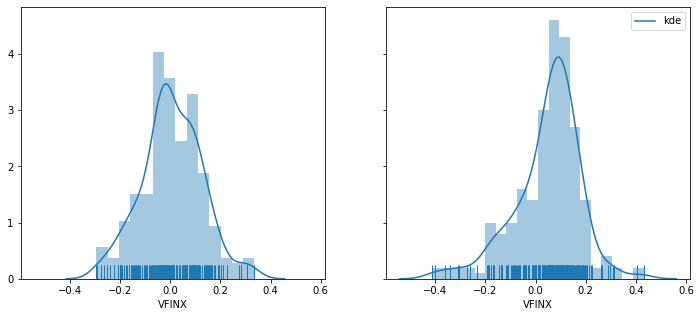

In [ ]:
out=optimizer_output
splithalf=out['params']['splithalf']
if splithalf==0:
    histogram_compare(out['learn_returns_df']['VFINX'],out['learn_returns_df']['VWEHX'])
elif splithalf>0:
    histogram_compare(out['learn_returns_df']['VFINX'],out['test_returns_df']['VFINX'])